In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


In [4]:
df = pd.read_csv("data/modelado/ds_modelado.csv")
df_invierno = df[df["estacion_del_anio"] == 3].copy()

train_df, val_df = train_test_split(
    df_invierno,
    test_size=0.2,
    random_state=42,
    stratify=df_invierno["año_intervalo"]
)

In [5]:
target = "N_arribos_intervalo"


cols_a_excluir = [
    "N_arribos_intervalo",  
    "N_salidas_intervalo",  
    "id_recorrido",
    "id_estacion_destino", #borre cosas de destino porq siento q son leakge onda el modelo puede aperender a contar en el ds cuantas columnas tenian como destino a x estacion y sabe q los arribos de esa x estacion entonces van a ser la suma de filas 
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",
]
features = [col for col in df_invierno.columns if col not in cols_a_excluir]

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

In [10]:
model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,        
    max_depth=50    
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=42)

In [11]:
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = root_mean_squared_error(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = root_mean_squared_error(y_val, y_val_pred)

print("Train:")
print(f"  MAE:  {mae_train:.2f}")
print(f"  RMSE: {rmse_train:.2f}")
print("Validation:")
print(f"  MAE:  {mae_val:.2f}")
print(f"  RMSE: {rmse_val:.2f}")

Train:
  MAE:  0.48
  RMSE: 0.71
Validation:
  MAE:  1.29
  RMSE: 1.89


In [12]:
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"R² Train: {r2_train:.3f}")
print(f"R² Val:   {r2_val:.3f}")

R² Train: 0.905
R² Val:   0.322


In [13]:
df_invierno["N_arribos_intervalo"].describe()

count    2.739160e+06
mean     2.738361e+00
std      2.291192e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.700000e+01
Name: N_arribos_intervalo, dtype: float64

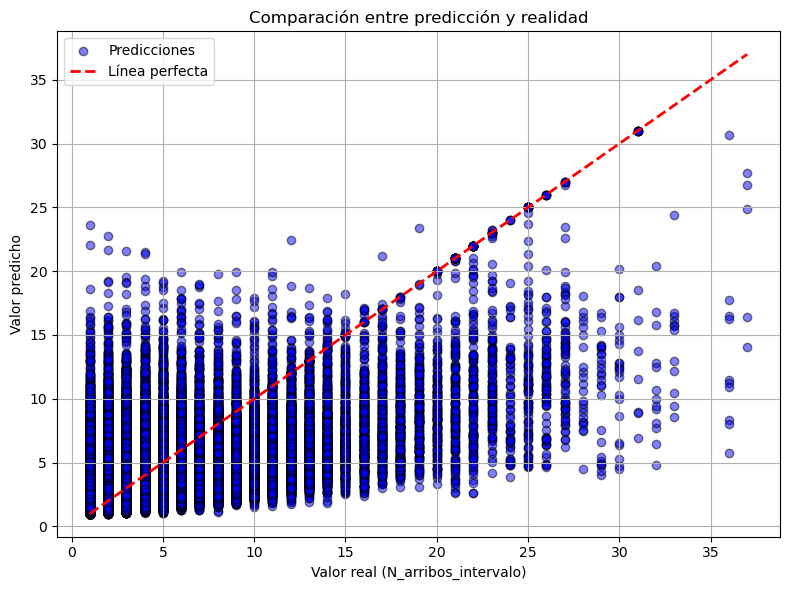

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Puntos reales vs predichos
plt.scatter(y_val, y_val_pred, color="blue", alpha=0.5, edgecolors="k", label="Predicciones")

# Línea perfecta
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Línea perfecta")

plt.xlabel("Valor real (N_arribos_intervalo)")
plt.ylabel("Valor predicho")
plt.title("Comparación entre predicción y realidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

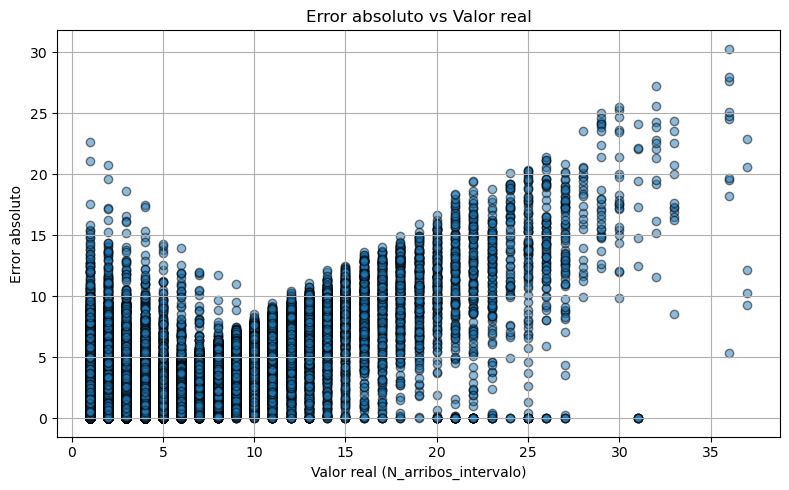

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular error absoluto
errores_abs = np.abs(y_val - y_val_pred)

plt.figure(figsize=(8, 5))
plt.scatter(y_val, errores_abs, alpha=0.5, edgecolors="k")
plt.xlabel("Valor real (N_arribos_intervalo)")
plt.ylabel("Error absoluto")
plt.title("Error absoluto vs Valor real")
plt.grid(True)
plt.tight_layout()
plt.show()

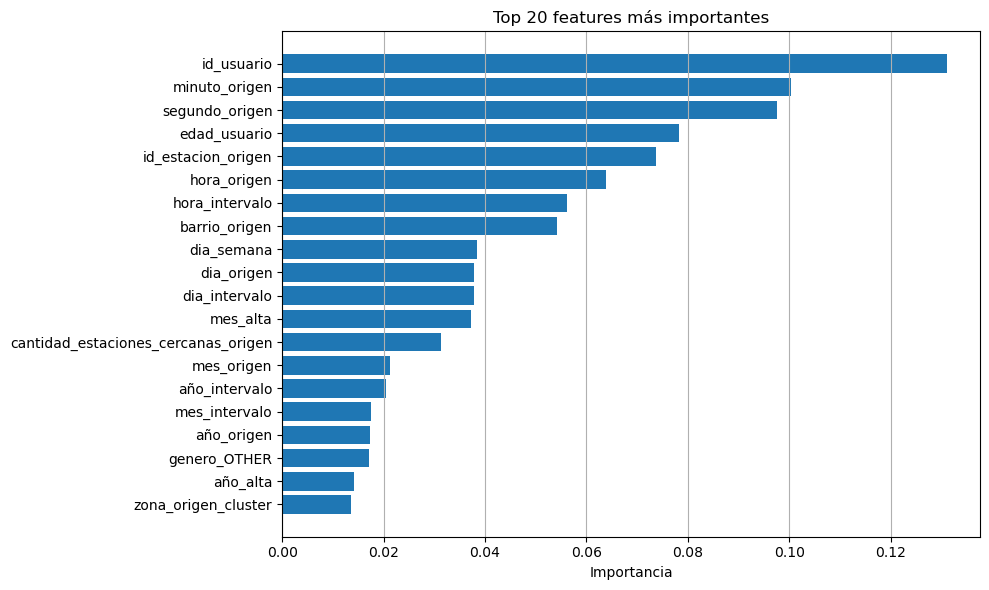

In [16]:
import pandas as pd

# Crear DataFrame con las importancias
importancias = model.feature_importances_
importancias_df = pd.DataFrame({
    "feature": X_train.columns,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False)

# Graficar las top 20
plt.figure(figsize=(10, 6))
plt.barh(importancias_df["feature"][:20][::-1], importancias_df["importancia"][:20][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 features más importantes")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

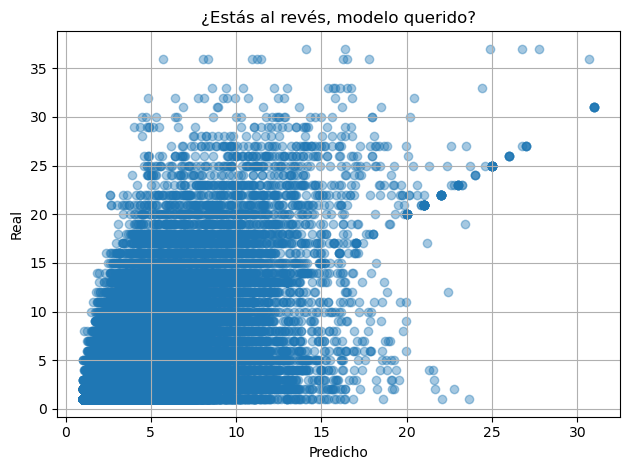

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_val_pred, y_val, alpha=0.4)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("¿Estás al revés, modelo querido?")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

for quantile in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    model_q90 = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
    model_q90.fit(X_train, y_train)

    # Predicción
    y_pred_q90 = model_q90.predict(X_val)

    # Métricas
    mae_q90 = mean_absolute_error(y_val, y_pred_q90)
    rmse_q90 = root_mean_squared_error(y_val, y_pred_q90)
    r2_q90 = r2_score(y_val, y_pred_q90)

    print(f"MAE (q={quantile}): {mae_q90:.2f}")
    print(f"RMSE (q={quantile}): {rmse_q90:.2f}")
    print(f"R²   (q={quantile}): {r2_q90:.3f}")

MAE (q=0.1): 1.74
RMSE (q=0.1): 2.88
R²   (q=0.1): -0.573
MAE (q=0.2): 1.73
RMSE (q=0.2): 2.87
R²   (q=0.2): -0.569
MAE (q=0.3): 1.72
RMSE (q=0.3): 2.86
R²   (q=0.3): -0.553
MAE (q=0.4): 1.32
RMSE (q=0.4): 2.28
R²   (q=0.4): 0.009
MAE (q=0.5): 1.28
RMSE (q=0.5): 2.12
R²   (q=0.5): 0.148
MAE (q=0.6): 1.32
RMSE (q=0.6): 2.03
R²   (q=0.6): 0.219
MAE (q=0.7): 1.46
RMSE (q=0.7): 2.04
R²   (q=0.7): 0.209
MAE (q=0.8): 1.79
RMSE (q=0.8): 2.31
R²   (q=0.8): -0.011
MAE (q=0.9): 2.56
RMSE (q=0.9): 3.14
R²   (q=0.9): -0.878


In [6]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

model_xgb = XGBRegressor(
    n_estimators=1000,
    max_depth=17,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📈 XGBoost Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

📈 XGBoost Metrics
MAE: 1.26
RMSE: 1.86
R²: 0.340


In [20]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

model_lgb = LGBMRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📈 LightGBM Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Number of data points in the train set: 2191328, number of used features: 26
[LightGBM] [Info] Start training from score 2.738941
📈 LightGBM Metrics
MAE: 1.30
RMSE: 1.93
R²: 0.293
